## Fake news detection ML Project
### Team members: Akanksha Arora & Suranjana Chowdhury

### Step 1: Importing Libraries needed for the analysis

In [1]:
# Importing libraries needed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing other libraries that may be needed
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dineshagrawal/Documents/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dineshagrawal/Documents/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

In [133]:
News_data = pd.read_csv('News.csv',index_col=0)
News_data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


### Step 2: Data Exploration

In [58]:
#1. Check number of rows and columns of the dataset downloaded
News_data.shape

(44919, 5)

In [59]:
#2. Checking if the data has any null values in any column
News_data.isnull().sum()

title       0
text        0
subject    21
date       21
class       0
dtype: int64

#### Real News: 1 (class label),     Fake news: 0 (class label)

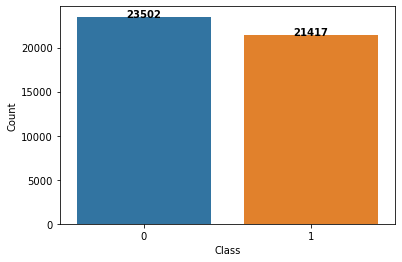

In [128]:
# Checking and visualizing the distribution of subject, date and classS
#1. Class
sns.countplot(data=News_data,
              x='class',
              order=News_data['class'].value_counts().index)

# get the counts for each category and sort by index
counts = News_data['class'].value_counts()

# add labels to the bars
for i, count in enumerate(counts):
    plt.annotate(str(count), xy=(i, count), ha='center', fontsize=10, fontweight='bold')

# set the axis labels
plt.xlabel('Class')
plt.ylabel('Count')

# show the plot
plt.show()
# In the given dataset, there is almost equal distribution of class variable (fake vs not fake)
# Real/ Not Fake: 1
# Fake: 0

In [61]:
#2. Subject
Summary_1= News_data.groupby(['subject'])["class"].count().reset_index(name="count_subject")
Summary_1

# Few of the values are noise while all other values tell news belong to which section

,subject,count_subject
0,Karl Marx is either a villain or a hero of so...,2
1,Politics According to the Bible and (with Bar...,1
2,a future nuclear family,2
3,and so is Mr. Katzenbach,2
4,claimed that hundreds of alternative media we...,2
5,decided not to seek re-election. While much o...,2
6,fell 5.6 percent Monday. Wynn Resortsslipped ...,2
7,high taxes,2
8,of which Soros is a major financier.Mercy Cor...,2
9,state systems with outsized pretensions to po...,2


In [62]:
#3. Date
News_data['Date_2'] = pd.to_datetime(News_data['date'], errors='coerce')
News_data["year"] = News_data.Date_2.dt.year
News_data["month"] = News_data.Date_2.dt.month
News_data["day"] = News_data.Date_2.dt.day
News_data.head()

,title,text,subject,date,class,Date_2,year,month,day
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,2017-12-31,2017.0,12.0,31.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,2017-12-31,2017.0,12.0,31.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,2017-12-30,2017.0,12.0,30.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,2017-12-29,2017.0,12.0,29.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,2017-12-25,2017.0,12.0,25.0


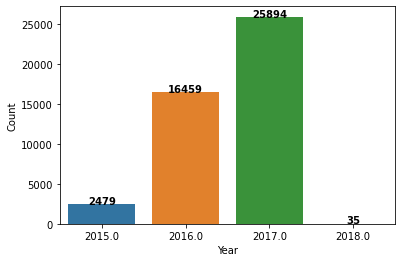

In [63]:
# create a sorted list of years
years = sorted(News_data['year'].dropna().unique())

# create the countplot
sns.countplot(data = News_data, x='year', order = years)

# get the counts for each category and sort by index
counts = News_data['year'].value_counts().sort_index()

# add labels to the bars
for i, count in enumerate(counts):
    plt.annotate(str(count), xy=(i, count), ha='center', fontsize=10, fontweight='bold')

# set the axis labels
plt.xlabel('Year')
plt.ylabel('Count')

# show the plot
plt.show()

In [64]:
# Shuffling the dataset: because dataset looks arranged on the basis of class and to avoid bias in the training method
News_data = News_data.sample(frac=1)
News_data.reset_index(inplace=True)
News_data.drop(["index"], axis=1, inplace=True)

In [31]:
# Defining function to clean the string column: "text"
def clean_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text

#### The code snippet below takes ~1 hour to run. Do not run again!!!

In [66]:
News_data2 = News_data.copy()

# Running the function defined on text column of news
Clean_text_values = clean_text(News_data['text'].values)
News_data2['text'] = Clean_text_values
News_data2.to_csv("News_data2.csv")

100%|███████████████████████████████████| 44919/44919 [2:06:31<00:00,  5.92it/s]


In [4]:
# Re-reading the csv file created in previous step
News_data2 = pd.read_csv('News_data2.csv',index_col=0)
News_data2.head()

,title,text,subject,date,class,Date_2,year,month,day
0,OUCH! The Left’s “Other Woman” Just Landed A D...,wow gonna leave markwhen arrested defacing pub...,politics,"Sep 16, 2016",0,2016-09-16,2016.0,9.0,16.0
1,VIDEO: The Dallas Shooting Agenda,daily shooter 21st century wirethe dallas snip...,Middle-east,"July 12, 2016",0,2016-07-12,2016.0,7.0,12.0
2,Trump says sets measure to punish companies th...,washington reuters us president donald trump s...,politicsNews,"October 10, 2017",1,2017-10-10,2017.0,10.0,10.0
3,"WIKILEAKS CLINTON CAMPAIGN EMAIL: Uneducated, ...",another stunning arrogant slam hillary support...,politics,"Oct 10, 2016",0,2016-10-10,2016.0,10.0,10.0
4,COMEDIAN TIM ALLEN On Hollywood Hypocrites: Th...,httpsyoutube0j4xprybslu,left-news,"Nov 22, 2016",0,2016-11-22,2016.0,11.0,22.0


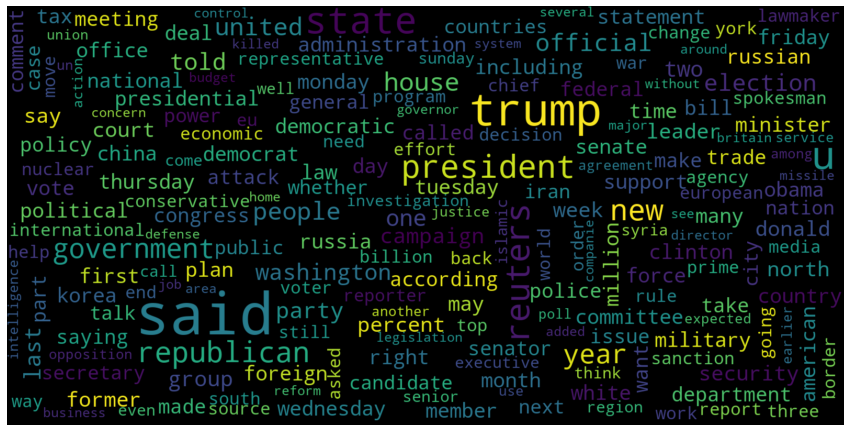

In [70]:
# Real
consolidated = ' '.join(
    word for word in News_data2['text'][News_data2['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

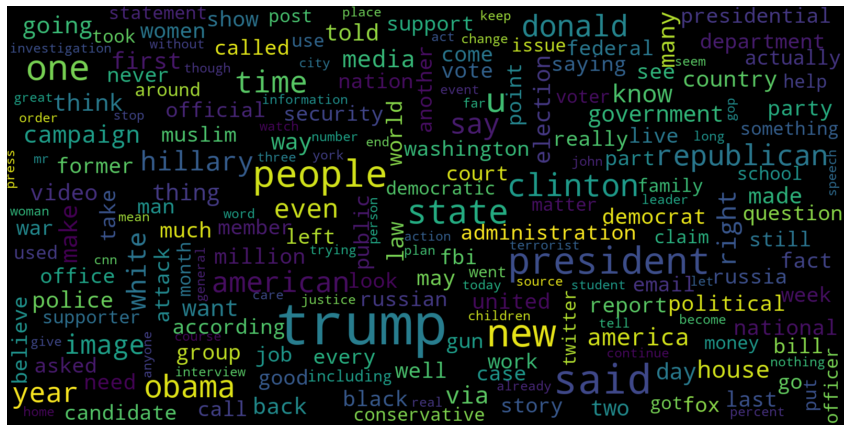

In [71]:
# Fake
consolidated = ' '.join(
    word for word in News_data2['text'][News_data2['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [130]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]

#### Checking how stopword removal help in 

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

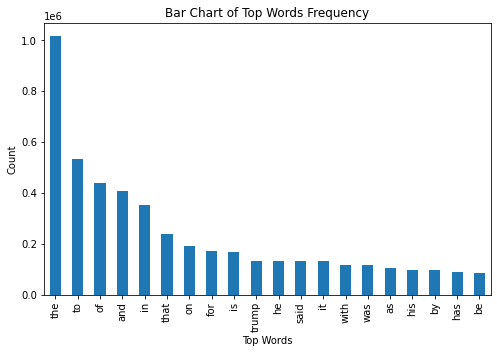

In [134]:
News_data = News_data.dropna()
common_words = get_top_n_words(News_data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
df1 = df1.groupby('Review').sum()['count'].sort_values(ascending=False)

df1.plot(
    kind='bar',
    figsize=(8, 5),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

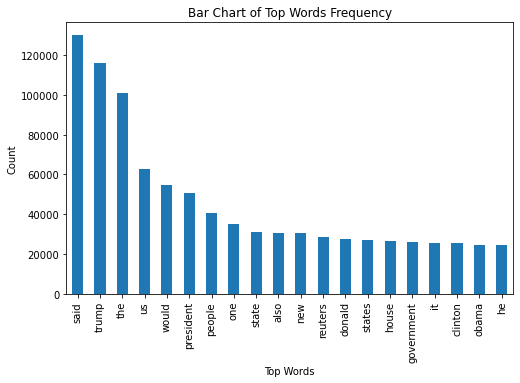

In [132]:
News_data2 = News_data2.dropna()
common_words = get_top_n_words(News_data2['text'], 20)
df2 = pd.DataFrame(common_words, columns=['Review', 'count'])
df2 = df2.groupby('Review').sum()['count'].sort_values(ascending=False)

df2.plot(
    kind='bar',
    figsize=(8, 5),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

#### Creating train and test dataset for model training

In [8]:
News_data2 = News_data2.dropna()
x_train, x_test, y_train, y_test = train_test_split(News_data2['text'], 
                                                    News_data2['class'], 
                                                    test_size=0.25)

In [9]:
x_test

19507    moscow reuters russia thursday named nine us g...
42790    washington reuters us defense secretary jim ma...
30766    vatican city reuters a vatican diplomat workin...
12915    washington reuters us senate majority leader m...
43407    did donald trump convince megyn kelly loyal fa...
                               ...                        
35905    while vicepresident mike pence gave commenceme...
37842    in case heard texas governor greg abbott order...
22651    cox s bazar bangladesh reuters four rohingya m...
29141    house republicans managed pass healthcare bill...
11350    just thought muslims cornered market abusing g...
Name: text, Length: 11059, dtype: object

In [10]:
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

## Training Models
#### 1. Logistic Regression

In [11]:
LR = LogisticRegression()
LR.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, LR.predict(x_train)))
print(accuracy_score(y_test, LR.predict(x_test)))

0.9933990415046569
0.9901437743014739


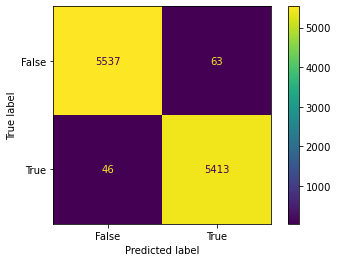

In [12]:
cm = metrics.confusion_matrix(y_test, LR.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

#### 2. Decision Tree

In [13]:
DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, DT.predict(x_train)))
print(accuracy_score(y_test, DT.predict(x_test)))

1.0
0.9962021882629533


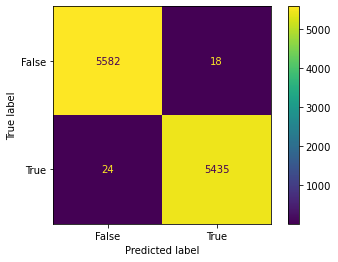

In [14]:
cm = metrics.confusion_matrix(y_test, DT.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

#### 3. GradientBoosting Classifier

In [15]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(x_train, y_train)

pred_gbc = GBC.predict(x_test)
GBC.score(x_test, y_test)

0.9952979473731802

In [16]:
# testing the model
print(accuracy_score(y_train, GBC.predict(x_train)))
print(accuracy_score(y_test, GBC.predict(x_test)))

0.9969858637007566
0.9952979473731802


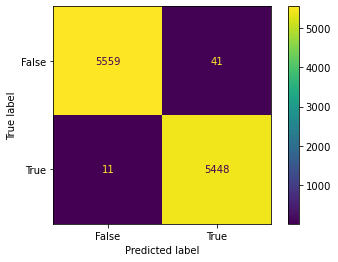

In [17]:
cm = metrics.confusion_matrix(y_test, GBC.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

#### 4. RandomForest Classifier

In [18]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train, y_train)

pred_rfc = RFC.predict(x_test)
RFC.score(x_test, y_test)

# testing the model
print(accuracy_score(y_train, RFC.predict(x_train)))
print(accuracy_score(y_test, RFC.predict(x_test)))

1.0
0.9897820779455647


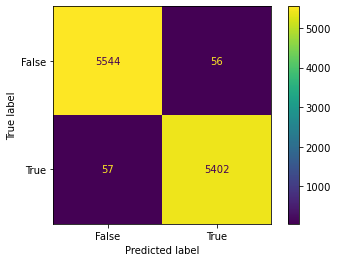

In [19]:
cm = metrics.confusion_matrix(y_test, RFC.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

#### 5. SVM

In [23]:
# The below code runs for a while..
# Train the SVM model
SVM = SVC(kernel='linear')
SVM.fit(x_train, y_train)

# predictions on the testing data
pred_svm = SVM.predict(x_test)

# Evaluating performance of the model
acc_score = accuracy_score(y_test, pred_svm)
conf_matrix_svm = confusion_matrix(y_test, pred_svm)
print("Accuracy Score:", acc_score)
print("Confusion Matrix:", conf_matrix_svm)

Accuracy Score: 0.9963830364409079
Confusion Matrix: [[5576   24]
 [  16 5443]]


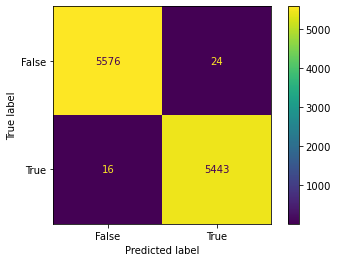

In [24]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, #display
                                            display_labels=[False, True]) 
cm_display.plot()
plt.show()

#### 6. Naive Bayes

In [26]:
# Train Naive Bayes model
NB = MultinomialNB()
NB.fit(x_train, y_train)

MultinomialNB()

In [27]:
# Predictions on the testing data
pred_nb = NB.predict(x_test)

# Performance of the model
acc_score = accuracy_score(y_test, pred_nb)
conf_matrix_nb = confusion_matrix(y_test, pred_nb)
print("Accuracy Score:", acc_score)
print("Confusion Matrix:", conf_matrix_nb)

Accuracy Score: 0.9492720860837327
Confusion Matrix: [[5293  307]
 [ 254 5205]]


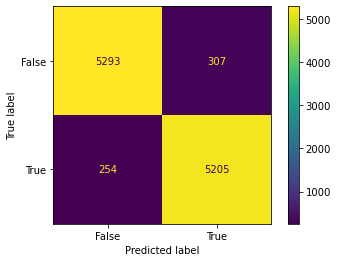

In [28]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nb, #display
                                            display_labels=[False, True]) 
cm_display.plot()
plt.show()

#### Defining a function to see how news are categoised

In [32]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    clean_text_values = clean_text(new_def_test['text'].values)
    new_xv_test = vectorization.transform(clean_text_values)
    pred_LR = LR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_GBC = GBC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)
    pred_SVM = SVM.predict(new_xv_test)
    pred_NB = NB.predict(new_xv_test)

    #return new_x_test
    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}  \nSVM Prediction: {}  \nNB Prediction: {}".format(output_lable(pred_LR[0]),                                                                                                       
                                                                                                                output_lable(pred_DT[0]), 
                                                                                                                output_lable(pred_GBC[0]), 
                                                                                                                output_lable(pred_RFC[0]),
                                                                                                                output_lable(pred_SVM[0]),
                                                                                                                output_lable(pred_NB[0])))



In [34]:
news = str(input())
manual_testing(news)

LONDON (Reuters) - LexisNexis, a provider of legal, regulatory and business information, said on Tuesday it had withdrawn two products from the Chinese market in March this year after it was asked to remove some content.  The issue of academic freedom in China hit the headlines this week after the leading British academic publisher,  Cambridge University Press, said it had complied with a request to block online access to some scholarly articles in China.  It later reversed its position.   Earlier this year LexisNexis Business Insight Solutions in China was asked to remove some content from its database,  LexisNexis said in a statement.  In March 2017, the company withdrew two products (Nexis and LexisNexis Academic) from the Chinese market.  LexisNexis is owned by information group Relx.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]




LR Prediction: Not A Fake News 
DT Prediction: Not A Fake News 
GBC Prediction: Not A Fake News 
RFC Prediction: Not A Fake News  
SVM Prediction: Not A Fake News  
NB Prediction: Not A Fake News


In [35]:
news = str(input())
manual_testing(news)

Vic Bishop Waking TimesOur reality is carefully constructed by powerful corporate, political and special interest sources in order to covertly sway public opinion. Blatant lies are often televised regarding terrorism, food, war, health, etc. They are fashioned to sway public opinion and condition viewers to accept what have become destructive societal norms.The practice of manipulating and controlling public opinion with distorted media messages has become so common that there is a whole industry formed around this. The entire role of this brainwashing industry is to figure out how to spin information to journalists, similar to the lobbying of government. It is never really clear just how much truth the journalists receive because the news industry has become complacent. The messages that it presents are shaped by corporate powers who often spend millions on advertising with the six conglomerates that own 90% of the media:General Electric (GE), News-Corp, Disney, Viacom, Time Warner, a

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]




LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News  
SVM Prediction: Fake News  
NB Prediction: Fake News


In [53]:
news = str(input())
manual_testing(news)

The U.K. government has summoned Moscow's ambassador to London after Kremlin critic and dual Russian/British citizen Vladimir Kara-Murza was jailed for 25 years in a case described by the U.K. Foreign Office as "politically motivated." Kara-Murza was arrested in April 2022 and charged with spreading false information about the Russian army in Ukraine. He was later also charged with "high treason" over speeches in which he criticized Kremlin policies and the war in Ukraine. He said that Russia had committed war crimes in Ukraine with cluster bombs in residential areas. These incidents have been independently documented but deemed false by Russian investigators. In a defiant address to the court last week before his sentencing, Kara-Murza said: "I only blame myself for one thing, I failed to convince enough of my compatriots and politicians in democratic countries of the danger that the current Kremlin regime poses for Russia and for the world." The court in Moscow also imposed a 400,000

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.09it/s]




LR Prediction: Not A Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Not A Fake News  
SVM Prediction: Not A Fake News  
NB Prediction: Not A Fake News


#### Comparison of Results

In [36]:
accuracy_1 = accuracy_score(y_test, LR.predict(x_test))
accuracy_2 = accuracy_score(y_test, SVM.predict(x_test))
accuracy_3 = accuracy_score(y_test, DT.predict(x_test))
accuracy_4 = accuracy_score(y_test, RFC.predict(x_test))
accuracy_5 = accuracy_score(y_test, GBC.predict(x_test))
accuracy_6 = accuracy_score(y_test, NB.predict(x_test))

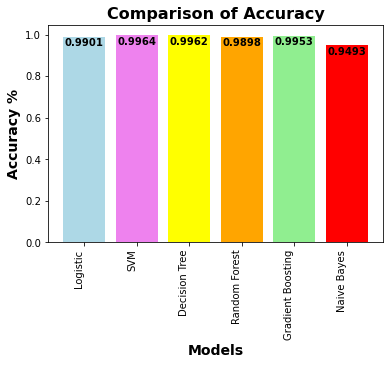

In [38]:
MODEL_NAMES = ['Logistic', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Naive Bayes']
COLORS_NAME = ['lightblue', 'violet', 'yellow', 'orange', 'lightgreen', 'red']
COMPARE_ACCURACY = [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6]

fig, ax = plt.subplots()
bars = ax.bar(MODEL_NAMES, COMPARE_ACCURACY, color=COLORS_NAME)
plt.xticks(rotation=90, ha='right')
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.03, '{:.4f}'.format(COMPARE_ACCURACY[i]), 
            ha='center', va='center', color='black', fontsize=10, fontweight='bold')


plt.title('Comparison of Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy %', fontsize=14, fontweight='bold')
plt.show()

#### Comparison of MSE

In [47]:
MSE_1 = mean_squared_error(y_test, LR.predict(x_test))
MSE_2 = mean_squared_error(y_test, SVM.predict(x_test))
MSE_3 = mean_squared_error(y_test, DT.predict(x_test))
MSE_4 = mean_squared_error(y_test, RFC.predict(x_test))
MSE_5 = mean_squared_error(y_test, GBC.predict(x_test))
MSE_6 = mean_squared_error(y_test, NB.predict(x_test))

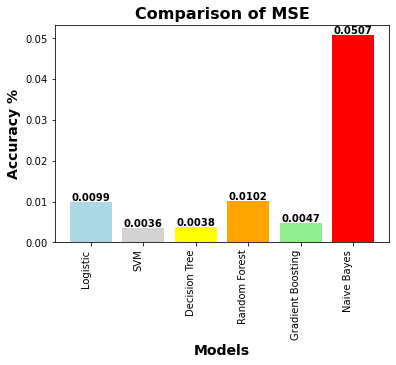

In [51]:
MODEL_NAMES = ['Logistic', 'SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Naive Bayes']
COLORS_NAME = ['lightblue', 'lightgrey', 'yellow', 'orange', 'lightgreen', 'red']
COMPARE_MSE = [MSE_1, MSE_2, MSE_3, MSE_4, MSE_5, MSE_6]

fig, ax = plt.subplots()
bars = ax.bar(MODEL_NAMES, COMPARE_MSE, color = COLORS_NAME)
plt.xticks(rotation=90, ha='right')
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001, '{:.4f}'.format(COMPARE_MSE[i]), 
            ha='center', va='center', color='black', fontsize=10, fontweight='bold')


plt.title('Comparison of MSE', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy %', fontsize=14, fontweight='bold')
plt.show()